In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from scipy import ndimage


sys.path.append('../shared')
from file_analyzer import FileAnalyzer


# Analyze your file
analyzer = FileAnalyzer('../../data/independent_expenditure_2024.csv')
analyzer.print_summary()

df = analyzer.get_dataframe()

# 2 Steps to cleaning data - first remove duplicates and then remove problematic spenders
# Remove duplicates keeping the latest file (amended reports)
df_clean = df.sort_values(['spe_id', 'exp_date', 'cand_id', 'file_num'])
df_clean = df_clean.drop_duplicates(subset=['spe_id', 'exp_date', 'cand_id', 'exp_amo'], keep='last')
df = df_clean

# Remove problematic spenders
spenders_to_remove = [
    'THE COMMITTEE OF 300',
    'THE COURT OF DIVINE JUSTICE', 
    'Republican Emo Girl',
    'The Masonic Illuminati Eye',
    'Gus Associates'
]

rows_to_remove = df['spe_nam'].isin(spenders_to_remove)
df = df[~df['spe_nam'].isin(spenders_to_remove)].copy()
df.head()
# https://www.fec.gov/campaign-finance-data/independent-expenditures-file-description/
presidential_candidates = df[df['can_office'] == 'P']['cand_name'].unique()
print("All Presidential Candidates:")
for candidate in presidential_candidates:
    print(candidate)

# df['can_office'].value_counts()


FILE ANALYSIS SUMMARY
📁 File: independent_expenditure_2024.csv
📊 Type: CSV
💾 Size: 18.6 MB
📈 Shape: (73403, 23)
🔢 Columns: 23
📋 Rows: 73403
All Presidential Candidates:
Harris, Kamala
HARRIS, KAMALA D
TRUMP, DONALD
TRUMP, DONALD J
TRUMP, DONALD J.
HARRIS, KAMALA
Biden, Joseph
HARRIS, KAMALA D.
Trump, Donald
BIDEN, JOSEPH
STEIN, JILL
KENNEDY, ROBERT
WEST, CORNEL
DESANTIS, RON
BIDEN, JOSEPH R JR
Walz, Tim
Haley, Nikki
DeSantis, Ron
Scott, Timothy
Pence, Mike
Ramaswamy, Vivek
Hutchinson, W.
Burgum, Doug
Christie, Chris
Kennedy, Robert
TRUMP, Donald
Biden, Joseph R
HALEY, NIKKI
SCOTT, TIMOTHY E.
Biden, Joseph R .Jr.
Biden, Joseph R. Jr.
Sonski, Peter
BIDEN, JOSEPH JR
Trump, Donald J.
Trump, DOnald
RAMASWAMY, VIVEK
Trump, Donal
HURD, WILLIAM
EZELL, WALTER MICHAEL
BIDEN, JOSEPH R
LEE, SUMMER
RYAN, TIMOTHY
GRAY, ADAM C.
SLOTKIN, ELISSA
BIDEN, JR., JOSEPH R.
SUAREZ, FRANCIS X.
Suarez, Francis
TRUMP, DONLAD
Desantis, Ron
SCOTT, TIMOTHY
DESANTIS, RONALD
CHRISTIE, CHRIS
KENNEDY, ROBERT F JR.
BIDE

In [112]:
df.head()

,cand_id,cand_name,spe_id,spe_nam,ele_type,can_office_state,can_office_dis,can_office,cand_pty_aff,exp_amo,exp_date,agg_amo,sup_opp,pur,pay,file_num,amndt_ind,tran_id,image_num,receipt_dat,fec_election_yr,prev_file_num,dissem_dt
1997,H2CO08020,"Caraveo, Yadira",C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,G,CO,8.0,H,DEMOCRATIC PARTY,410000.0,10-OCT-24,410000.00,S,Media Buy and Production,Strother Nuckels Strategies,1827568,N,ECDBC8A4E37664467818,202410159686550268,15-OCT-24,2024,NaN,15-OCT-24
1998,H8IA02043,"Miller-Meeks, Mariannette",C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,G,IA,1.0,H,REPUBLICAN PARTY,425000.0,10-OCT-24,425000.00,S,Media Buy and Production,"Prime Media Partners, LLC",1836238,N,E1FA5CED6F0C144D6969,202410239710110665,23-OCT-24,2024,NaN,23-OCT-24
18682,H2NY04277,"Desposito, Anthony",C00000935,DCCC,G,NY,4.0,H,REPUBLICAN PARTY,15000.0,01-OCT-24,2862008.09,O,Digital Media - Production Estimate,"Charles Rocha dba Solidarity Strategies, LLC",1822077,A1,SE-1085596,202410099684848881,09-OCT-24,2024,1819815.0,01-OCT-24
18872,H2WA03100,"Kent, Joseph",C00000935,DCCC,G,WA,3.0,H,REPUBLICAN PARTY,10000.0,01-OCT-24,2682891.00,O,Digital Media - Production Estimate,Wavelength Strategy LLC,1822077,A1,SE-1085598,202410099684848894,09-OCT-24,2024,1819815.0,01-OCT-24
18873,H2WA03100,"Kent, Joseph",C00000935,DCCC,G,WA,3.0,H,REPUBLICAN PARTY,15670.0,01-OCT-24,2682891.00,O,Media Production - Estimate,ZTribeca LLC,1822077,A1,SE-1085599,202410099684848894,09-OCT-24,2024,1819815.0,01-OCT-24


In [113]:
# get numbers of unique candidate names
candidate_counts = df['cand_name'].value_counts()
print(candidate_counts)


cand_name
Harris, Kamala         5205
Trump, Donald          3225
HARRIS, KAMALA         2925
TRUMP, DONALD          1710
TRUMP, DONALD J.       1050
                       ... 
WITT, GLORIA              1
Barnes, Mandela           1
Nguyen, Kim               1
Roy, Chip                 1
Gillibrand, Kirsten       1
Name: count, Length: 1293, dtype: int64


In [114]:

# Date parsing for plotting
df.loc[:, 'exp_date_parsed'] = pd.to_datetime(df['exp_date'], format='%d-%b-%y', errors='coerce')
df.loc[:, 'exp_month'] = df['exp_date_parsed'].dt.to_period('M')


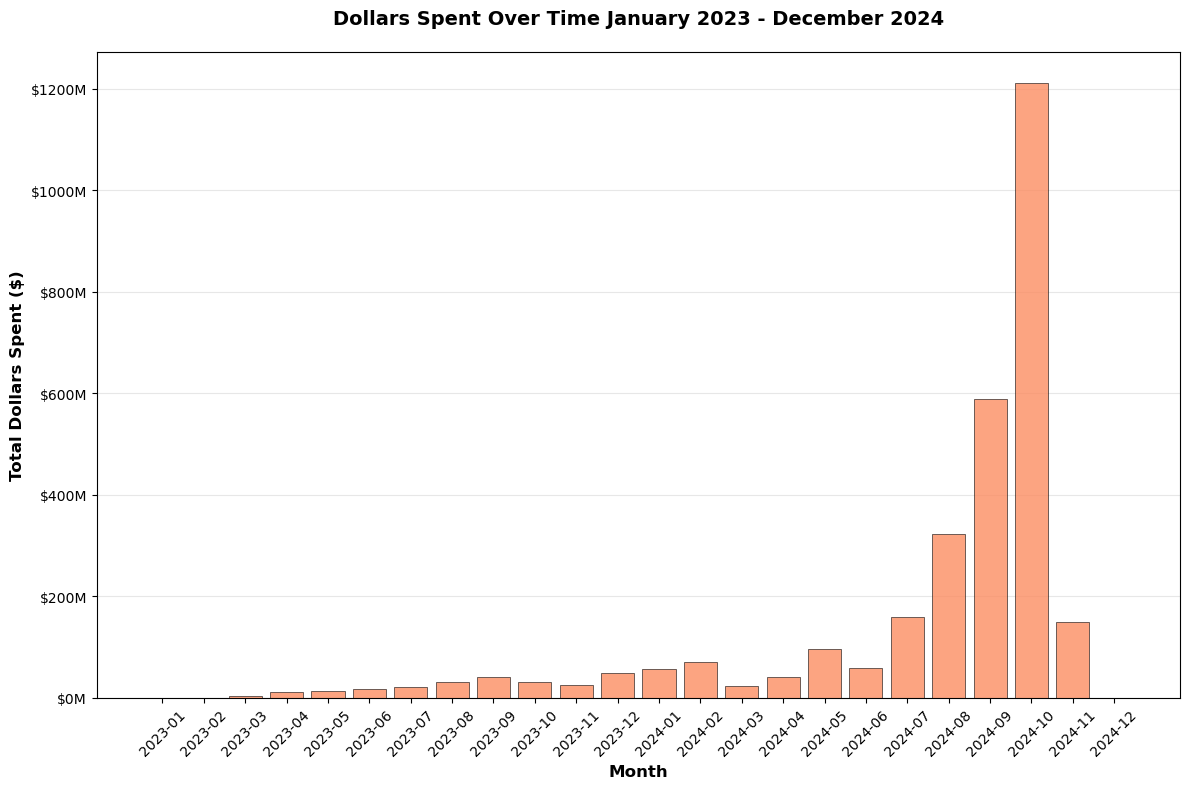

In [115]:
# Plot dollars spent over time (similar to expenditures plot but using sum of amounts)
plt.figure(figsize=(12, 8))
monthly_amounts = df.groupby('exp_month')['exp_amo'].sum().sort_index()

colors = sns.color_palette('Set2', len(monthly_amounts))
plt.bar(range(len(monthly_amounts)), monthly_amounts.values, 
        color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Dollars Spent ($)', fontsize=12, fontweight='bold')
plt.title('Dollars Spent Over Time January 2023 - December 2024', 
            fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(monthly_amounts)), monthly_amounts.index, rotation=45)

# Format y-axis to show amounts in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.grid(axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/dollars_spent_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


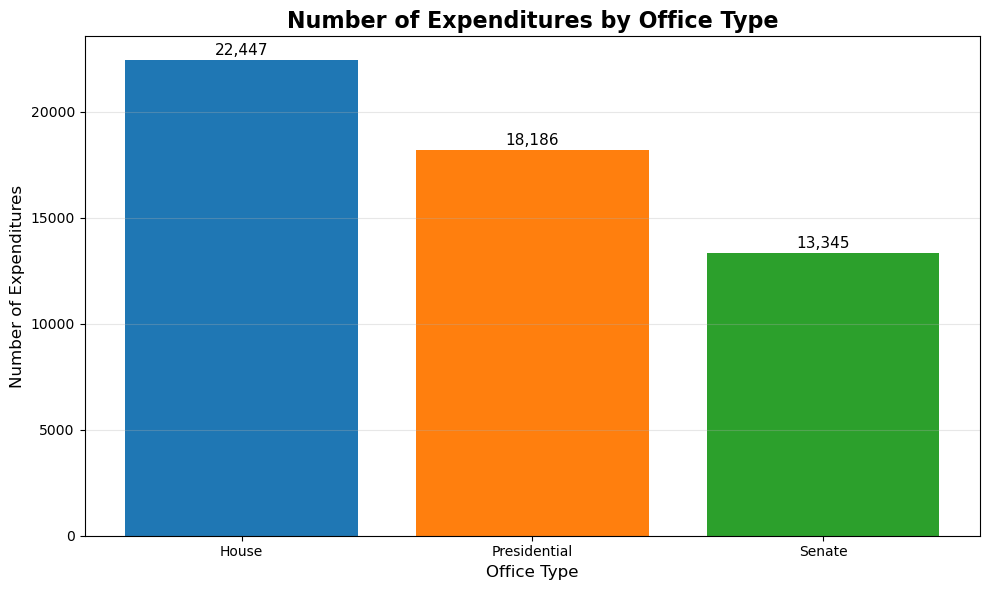

Expenditure counts by office:
House: 22,447
Presidential: 18,186
Senate: 13,345


In [116]:
# Create bar chart for expenditures by can_office
can_office_counts = df['can_office'].value_counts()

# Map the codes to full names
office_names = {'H': 'House', 'P': 'Presidential', 'S': 'Senate'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar([office_names[code] for code in can_office_counts.index], 
               can_office_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Customize the plot
plt.title('Number of Expenditures by Office Type', fontsize=16, fontweight='bold')
plt.xlabel('Office Type', fontsize=12)
plt.ylabel('Number of Expenditures', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print the actual numbers
print("Expenditure counts by office:")
for code, count in can_office_counts.items():
    print(f"{office_names[code]}: {count:,}")


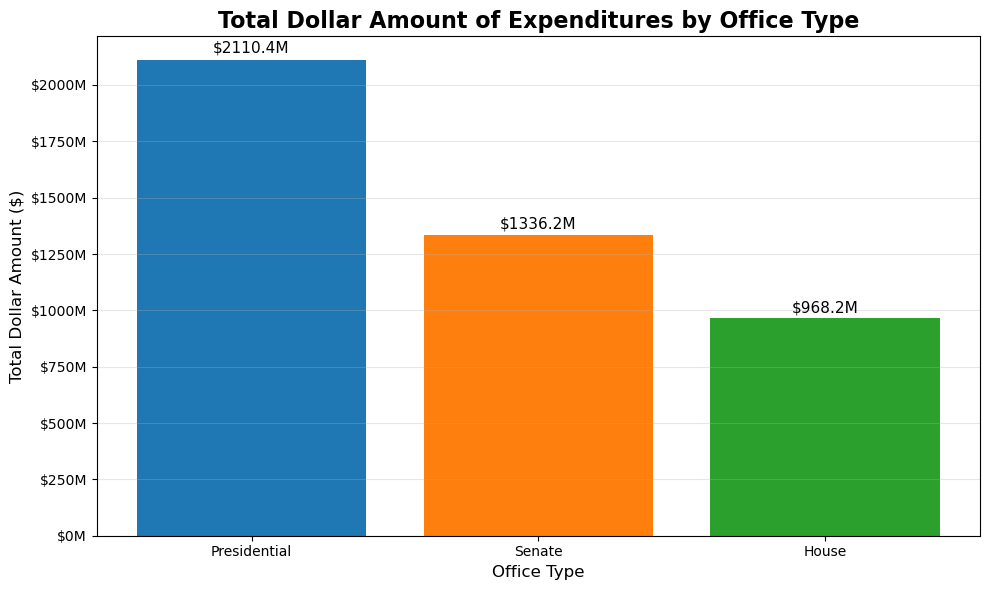

Total dollar amounts by office:
Presidential: $2,110,373,309.87
Senate: $1,336,188,179.78
House: $968,203,829.64


In [117]:
# Create bar chart for total dollar amounts by can_office
can_office_amounts = df.groupby('can_office')['exp_amo'].sum().sort_values(ascending=False)

# Map the codes to full names
office_names = {'H': 'House', 'P': 'Presidential', 'S': 'Senate'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar([office_names[code] for code in can_office_amounts.index], 
               can_office_amounts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Customize the plot
plt.title('Total Dollar Amount of Expenditures by Office Type', fontsize=16, fontweight='bold')
plt.xlabel('Office Type', fontsize=12)
plt.ylabel('Total Dollar Amount ($)', fontsize=12)

# Add value labels on top of bars (formatted as millions)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'${height/1e6:.1f}M', ha='center', va='bottom', fontsize=11)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Format y-axis to show millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print the actual amounts
print("Total dollar amounts by office:")
for code, amount in can_office_amounts.items():
    print(f"{office_names[code]}: ${amount:,.2f}")


In [118]:
# Get total dollar amount spent across all time periods
total_spent = df['exp_amo'].sum()
print(f"Total amount spent across all time periods: ${total_spent:,.2f}")


Total amount spent across all time periods: $4,415,014,497.82


Top 20 spenders by total dollar amount:
spe_nam
FF PAC                                                                                    4.884767e+08
MAKE AMERICA GREAT AGAIN INC.                                                             3.811664e+08
WinSenate                                                                                 2.971746e+08
Senate Leadership Fund                                                                    2.110850e+08
Congressional Leadership Fund                                                             2.015903e+08
HMP                                                                                       1.725976e+08
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action    1.398614e+08
Food & Water Action                                                                       1.142088e+08
PRESERVE AMERICA PAC                                                                      1.123219e+08
America PAC              

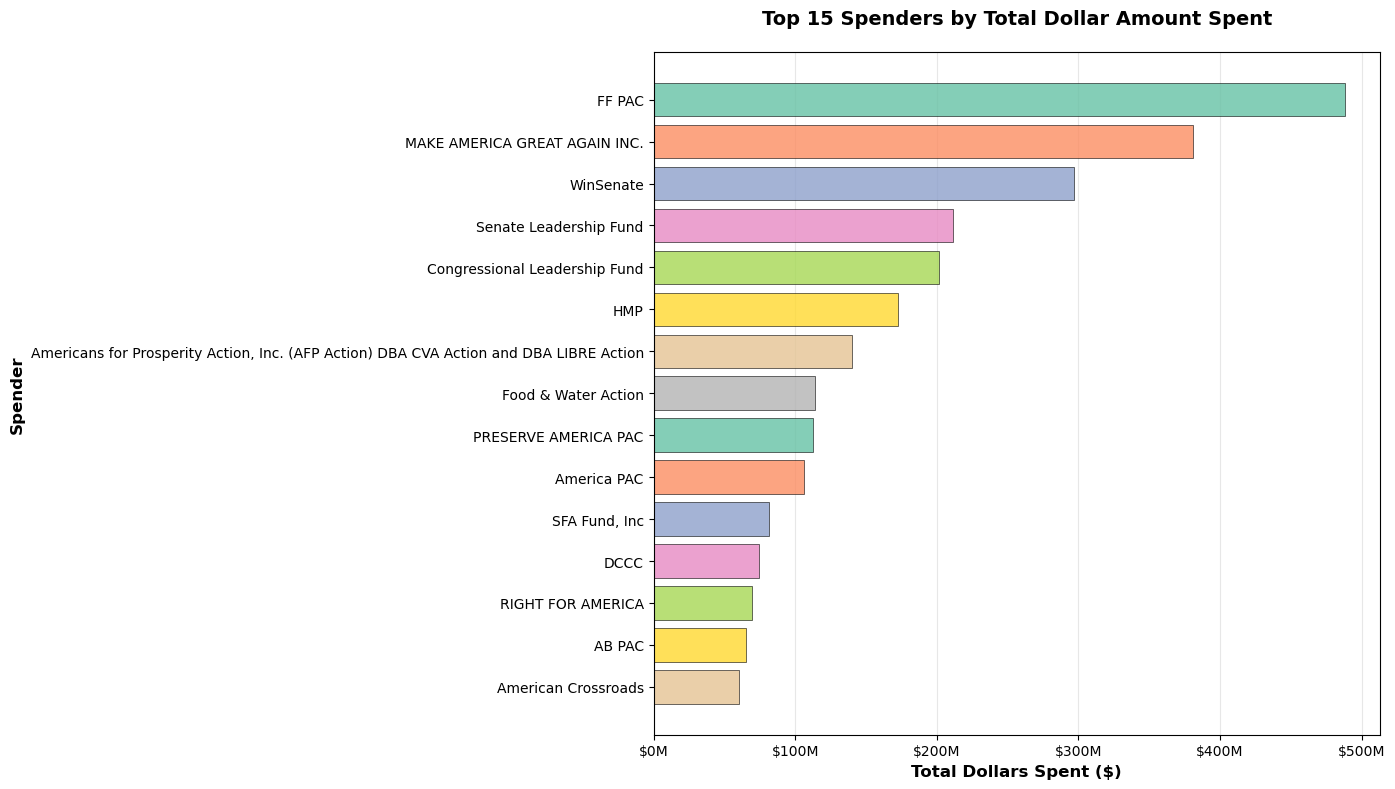


Total amount spent by top 15 spenders: $2,576,088,554.88
Percentage of total spending by top 15: 58.3%


In [119]:
# Calculate total dollar amounts spent by each spender
spender_amounts = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False)

print(f"Top 20 spenders by total dollar amount:")
print(spender_amounts.head(20))
plt.figure(figsize=(14, 8))

top_spenders = spender_amounts.head(15)

colors = sns.color_palette('Set2', len(top_spenders))

bars = plt.barh(range(len(top_spenders)), top_spenders.values, 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Total Dollars Spent ($)', fontsize=12, fontweight='bold')
plt.ylabel('Spender', fontsize=12, fontweight='bold')
plt.title('Top 15 Spenders by Total Dollar Amount Spent', 
          fontsize=14, fontweight='bold', pad=20)

plt.yticks(range(len(top_spenders)), top_spenders.index)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.grid(axis='x', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('images/top_spenders_by_amount.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal amount spent by top 15 spenders: ${top_spenders.sum():,.2f}")
print(f"Percentage of total spending by top 15: {(top_spenders.sum() / df['exp_amo'].sum()) * 100:.1f}%")


In [120]:
pd.set_option('display.max_columns', None)
# df.head()
df['cand_pty_aff'].value_counts()
# df[df['cand_name'].str.contains('Nate') & (df['exp_amo'] >= 123) & (df['exp_amo'] <= 20000)]
# df[df['exp_amo'] >= 8000000]

cand_pty_aff
DEMOCRATIC PARTY           23818
REPUBLICAN PARTY           21792
INDEPENDENT                  572
DEMOCRATIC-FARMER-LABOR      163
LIBERTARIAN PARTY             54
OTHER                         28
GREEN PARTY                   22
UNKNOWN                       16
UNAFFILIATED                   4
Name: count, dtype: int64

In [121]:
candidate_counts = df['cand_name'].value_counts()

print(f"Total number of distinct candidates: {len(candidate_counts)}")
print(f"\nTop 20 candidates by number of expenditures:")
print(candidate_counts.head(20))


Total number of distinct candidates: 1293

Top 20 candidates by number of expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
BILIRAKIS, GUS         459
ROSEN, JACKY           443
MORENO, BERNIE         441
BALDWIN, TAMMY         435
Baldwin, Tammy         419
SHAH, AMISH            376
ENGEL, KIRSTEN         370
BROWN, SAM             370
Biden, Joseph          339
RUTHERFORD, JOHN       333
Name: count, dtype: int64


In [122]:
print("Summary statistics:")
print(f"Total expenditures: {len(df)}")
print(f"Unique candidates: {df['cand_name'].nunique()}")
print(f"Average expenditures per candidate: {len(df) / df['cand_name'].nunique():.2f}")

print(f"\nCandidates with most expenditures:")
print(candidate_counts.head(10))

print(f"\nCandidates with least expenditures (appearing only once):")
single_occurrence = candidate_counts[candidate_counts == 1]
print(f"Number of candidates appearing only once: {len(single_occurrence)}")
print(single_occurrence.head(10))


Summary statistics:
Total expenditures: 53991
Unique candidates: 1293
Average expenditures per candidate: 41.76

Candidates with most expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
Name: count, dtype: int64

Candidates with least expenditures (appearing only once):
Number of candidates appearing only once: 228
cand_name
BAECHLER, MARY                 1
COUHGLIN, KEVIN                1
SIDDIQI, IMRAAN                1
BARR, CALLIE                   1
0'Callahan, Conor              1
Espaillat, Adriano             1
Nick, Lalota                   1
MCFARLANE, WALTER JAMES III    1
BILLIPS, NATHAN                1
Terry, Randell                 1
Name: count, dtype: int64


In [123]:
spender_counts = df['spe_nam'].value_counts()

print(f"Total number of distinct spenders: {len(spender_counts)}")
print(f"\nTop 20 spenders by number of expenditures:")
print(spender_counts.head(20))

Total number of distinct spenders: 1069

Top 20 spenders by number of expenditures:
spe_nam
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action    2280
Congressional Leadership Fund                                                             1609
Worker Power                                                                              1485
SENATE CONSERVATIVES FUND                                                                 1367
RED SENATE                                                                                1279
SUPPORT AMERICA'S POLICE PAC                                                              1121
HMP                                                                                       1012
Republican Accountability PAC                                                              972
SOS AMERICA PAC                                                                            825
Working America                                      

In [124]:
# Examine the four key columns
columns_to_examine = ['spe_nam', 'cand_pty_aff', 'pur', 'exp_amo']

print("Column Information:")
print("=" * 50)
for col in columns_to_examine:
    print(f"\n{col}:")
    print(f"  Data type: {df[col].dtype}")
    print(f"  Non-null count: {df[col].notna().sum()}")
    print(f"  Null count: {df[col].isna().sum()}")
    print(f"  Unique values: {df[col].nunique()}")
    
    if col == 'exp_amo':
        print(f"  Min value: ${df[col].min():,.2f}")
        print(f"  Max value: ${df[col].max():,.2f}")
        print(f"  Mean value: ${df[col].mean():,.2f}")
        print(f"  Median value: ${df[col].median():,.2f}")
    else:
        print(f"  Sample values: {df[col].dropna().head(5).tolist()}")


Column Information:

spe_nam:
  Data type: object
  Non-null count: 53988
  Null count: 3
  Unique values: 1069
  Sample values: ['AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'DCCC', 'DCCC', 'DCCC']

cand_pty_aff:
  Data type: object
  Non-null count: 46469
  Null count: 7522
  Unique values: 9
  Sample values: ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY']

pur:
  Data type: object
  Non-null count: 53982
  Null count: 9
  Unique values: 5445
  Sample values: ['Media Buy and Production', 'Media Buy and Production', 'Digital Media -  Production Estimate', 'Digital Media -  Production Estimate', 'Media Production - Estimate']

exp_amo:
  Data type: float64
  Non-null count: 53991
  Null count: 0
  Unique values: 30214
  Min value: $-580,000.00
  Max value: $114,056,874.00
  Mean value: $81,773.16
  Median value: $2,760.00


In [125]:
print("TOP 15 SPENDERS BY DOLLAR AMOUNT:")
print("=" * 50)
top_spenders_by_amount = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False).head(15)
for spender, total_amount in top_spenders_by_amount.items():
    print(f"{spender}: ${total_amount:,.2f}")

print(f"\nTotal unique spenders: {df['spe_nam'].nunique():,}")


TOP 15 SPENDERS BY DOLLAR AMOUNT:
FF PAC: $488,476,651.35
MAKE AMERICA GREAT AGAIN INC.: $381,166,419.49
WinSenate: $297,174,584.54
Senate Leadership Fund: $211,084,995.66
Congressional Leadership Fund: $201,590,329.26
HMP: $172,597,570.83
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action: $139,861,364.79
Food & Water Action: $114,208,840.16
PRESERVE AMERICA PAC: $112,321,879.52
America PAC: $106,300,393.66
SFA Fund, Inc: $81,182,993.18
DCCC: $74,778,403.64
RIGHT FOR AMERICA: $69,583,233.16
AB PAC: $65,547,002.18
American Crossroads: $60,213,893.46

Total unique spenders: 1,069


In [126]:
print("CANDIDATE PARTY AFFILIATIONS:")
print("=" * 50)
party_counts = df['cand_pty_aff'].value_counts()
for party, count in party_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{party}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal unique parties: {df['cand_pty_aff'].nunique()}")
print(f"Missing party data: {df['cand_pty_aff'].isna().sum():,} ({df['cand_pty_aff'].isna().sum()/len(df)*100:.1f}%)")


CANDIDATE PARTY AFFILIATIONS:
DEMOCRATIC PARTY: 23,818 (44.1%)
REPUBLICAN PARTY: 21,792 (40.4%)
INDEPENDENT: 572 (1.1%)
DEMOCRATIC-FARMER-LABOR: 163 (0.3%)
LIBERTARIAN PARTY: 54 (0.1%)
OTHER: 28 (0.1%)
GREEN PARTY: 22 (0.0%)
UNKNOWN: 16 (0.0%)
UNAFFILIATED: 4 (0.0%)

Total unique parties: 9
Missing party data: 7,522 (13.9%)


EXPENDITURE PURPOSES:


Payroll: 1,455 (2.7%)
DIGITAL ADS: 1,249 (2.3%)
PHONEBANK PAYROLL SERVICES(ESTIMATE): 1,128 (2.1%)
PHONEBANK IT/TECH SUPPORT(ESTIMATE): 1,117 (2.1%)
CAGING AND DATABASE SERVICES(ESTIMATE): 1,106 (2.0%)
LEADS / PHONE LISTS(ESTIMATE): 1,065 (2.0%)
MEDIA PLACEMENT: 975 (1.8%)
MEDIA PRODUCTION: 889 (1.6%)
Digital Advertising: 758 (1.4%)
MEDIA: 610 (1.1%)
MAILER POSTAGE: 609 (1.1%)
DIRECT MAIL: 557 (1.0%)
TEXT MESSAGES: 471 (0.9%)
Direct Mail: 456 (0.8%)
MMS Messaging (Estimate): 406 (0.8%)
Canvassing: 396 (0.7%)
PRINTING / POSTAGE: 395 (0.7%)
Leads / Phone Lists(Estimate): 394 (0.7%)
PHONEBANK IT/TECH SUPPORT(Estimate): 391 (0.7%)
Caging and Database Services(Estimate): 391 (0.7%)
Phonebank Payroll Services(Estimate): 391 (0.7%)
CANVASSING: 382 (0.7%)
Media Buy: 358 (0.7%)
Digital Advertising - Estimate: 334 (0.6%)
DIGITAL PLACEMENT: 328 (0.6%)
Media Production - Estimate: 325 (0.6%)
MAILER PRODUCTION: 325 (0.6%)
Digital advertising: 310 (0.6%)
MMS Messaging: 283 (0.5%)
Advertising; Billbo

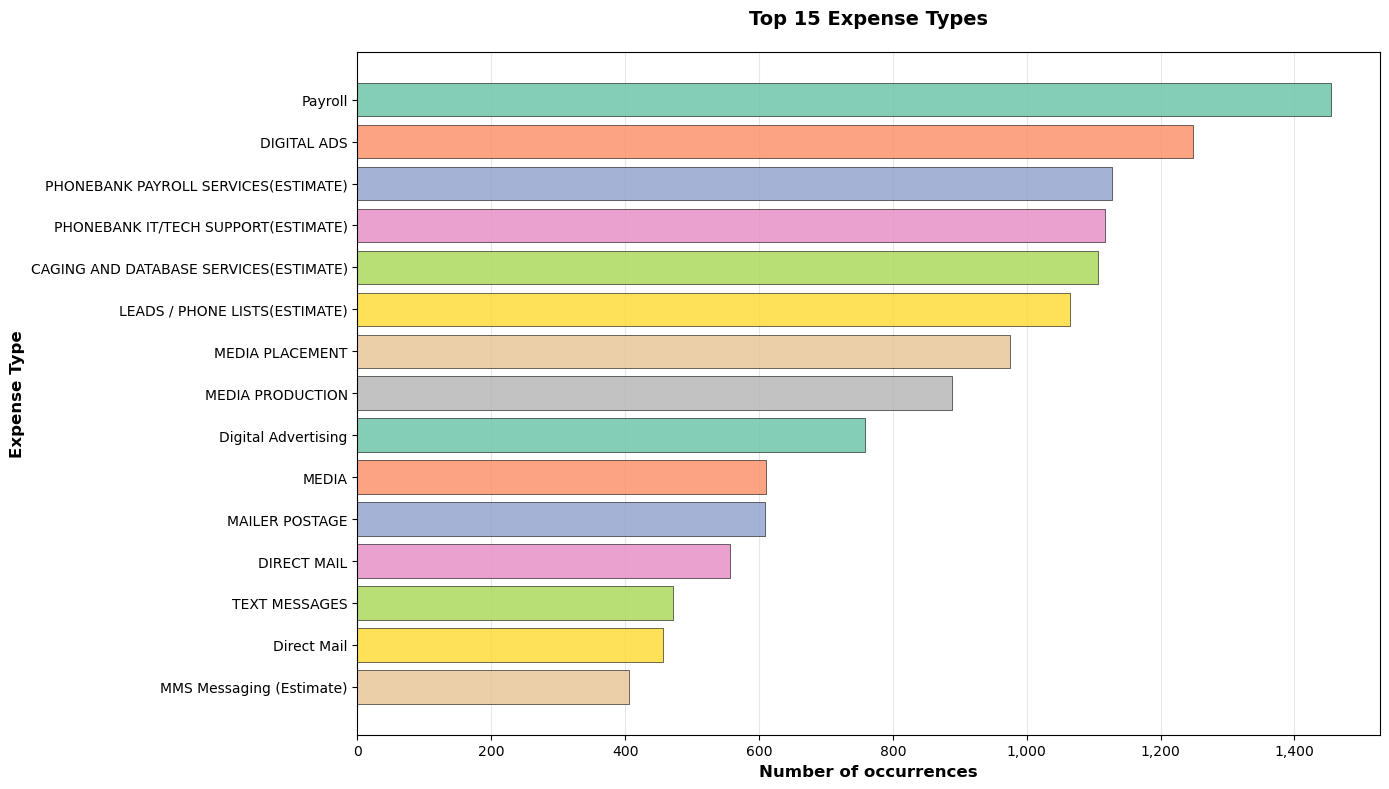

Percentage of total expenditures by top 15 types: 23.8%


In [127]:
print("EXPENDITURE PURPOSES:")
print("=" * 50)
purpose_counts = df['pur'].value_counts()
for purpose, count in purpose_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{purpose}: {count:,} ({percentage:.1f}%)")

# Get top 15 expense types by count
top_15_purposes = purpose_counts.head(15)

plt.figure(figsize=(14, 8))

colors = sns.color_palette('Set2', len(top_15_purposes))

bars = plt.barh(range(len(top_15_purposes)), top_15_purposes.values, 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Number of occurrences', fontsize=12, fontweight='bold')
plt.ylabel('Expense Type', fontsize=12, fontweight='bold')
plt.title('Top 15 Expense Types', 
          fontsize=14, fontweight='bold', pad=20)

plt.yticks(range(len(top_15_purposes)), top_15_purposes.index)

# Format x-axis as counts (not currency)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.grid(axis='x', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('images/top_expense_types_by_count.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Percentage of total expenditures by top 15 types: {(top_15_purposes.sum() / purpose_counts.sum()) * 100:.1f}%")



In [128]:
print("EXPENDITURE AMOUNTS ANALYSIS:")
print("=" * 50)

print(f"Total expenditures: {len(df):,}")
print(f"Total amount spent: ${df['exp_amo'].sum():,.2f}")
print(f"Average expenditure: ${df['exp_amo'].mean():,.2f}")
print(f"Median expenditure: ${df['exp_amo'].median():,.2f}")
print(f"Largest single expenditure: ${df['exp_amo'].max():,.2f}")
print(f"Smallest single expenditure: ${df['exp_amo'].min():,.2f}")

# Distribution by amount ranges
print(f"\nEXPENDITURE AMOUNT DISTRIBUTION:")
ranges = [
    (0, 100, "Under $100"),
    (100, 1000, "$100 - $1,000"),
    (1000, 10000, "$1,000 - $10,000"),
    (10000, 100000, "$10,000 - $100,000"),
    (100000, float('inf'), "Over $100,000")
]

for min_amt, max_amt, label in ranges:
    if max_amt == float('inf'):
        count = len(df[df['exp_amo'] >= min_amt])
    else:
        count = len(df[(df['exp_amo'] >= min_amt) & (df['exp_amo'] < max_amt)])
    percentage = (count / len(df)) * 100
    print(f"{label}: {count:,} ({percentage:.1f}%)")


EXPENDITURE AMOUNTS ANALYSIS:
Total expenditures: 53,991
Total amount spent: $4,415,014,497.82
Average expenditure: $81,773.16
Median expenditure: $2,760.00
Largest single expenditure: $114,056,874.00
Smallest single expenditure: $-580,000.00

EXPENDITURE AMOUNT DISTRIBUTION:
Under $100: 8,212 (15.2%)
$100 - $1,000: 13,211 (24.5%)
$1,000 - $10,000: 12,937 (24.0%)
$10,000 - $100,000: 13,697 (25.4%)
Over $100,000: 5,915 (11.0%)


In [129]:
print("LARGEST EXPENDITURES:")
print("=" * 50)
top_expenditures = df.nlargest(10, 'exp_amo')[['spe_nam', 'cand_name', 'cand_pty_aff', 'pur', 'exp_amo']]
for idx, row in top_expenditures.iterrows():
    print(f"${row['exp_amo']:,.2f} - {row['spe_nam']} → {row['cand_name']} ({row['cand_pty_aff']}) - {row['pur']}")

print(f"\nLARGEST SPENDERS BY TOTAL AMOUNT:")
print("=" * 50)
spender_totals = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False).head(10)
for spender, total in spender_totals.items():
    print(f"{spender}: ${total:,.2f}")


LARGEST EXPENDITURES:
$114,056,874.00 - Food & Water Action → Harris, Kamala (DEMOCRATIC PARTY) - Voter outreach
$30,033,271.32 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$24,083,279.00 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,798,392.46 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,147,260.79 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,102,885.83 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,016,914.21 - FF PAC → Harris, Kamala (DEMOCRATIC PARTY) - Media Buy and Ad Servicing (Estimate)
$18,986,237.00 - FF PAC → Harris, Kamala (DEMOCRATIC PARTY) - Media Buy and Ad Servicing (Estimate)
$17,300,000.00 - RBG PAC → TRUMP, DONALD J. (REPUBLICAN PARTY) - DIGITAL MEDIA
$16,717,500.00 - Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE A

In [130]:
spending_purposes = df['pur'].value_counts()

print(f"Total number of distinct spending purposes: {len(spending_purposes)}")
print(f"\nTop 20 spending purposes by number of expenditures:")
print(spending_purposes.head(20))



Total number of distinct spending purposes: 5445

Top 20 spending purposes by number of expenditures:
pur
Payroll                                   1455
DIGITAL ADS                               1249
PHONEBANK PAYROLL SERVICES(ESTIMATE)      1128
PHONEBANK IT/TECH SUPPORT(ESTIMATE)       1117
CAGING AND DATABASE SERVICES(ESTIMATE)    1106
LEADS / PHONE LISTS(ESTIMATE)             1065
MEDIA PLACEMENT                            975
MEDIA PRODUCTION                           889
Digital Advertising                        758
MEDIA                                      610
MAILER POSTAGE                             609
DIRECT MAIL                                557
TEXT MESSAGES                              471
Direct Mail                                456
MMS Messaging (Estimate)                   406
Canvassing                                 396
PRINTING / POSTAGE                         395
Leads / Phone Lists(Estimate)              394
PHONEBANK IT/TECH SUPPORT(Estimate)        391
C

/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_22610/27582385.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, y='Category', x='Percentage',


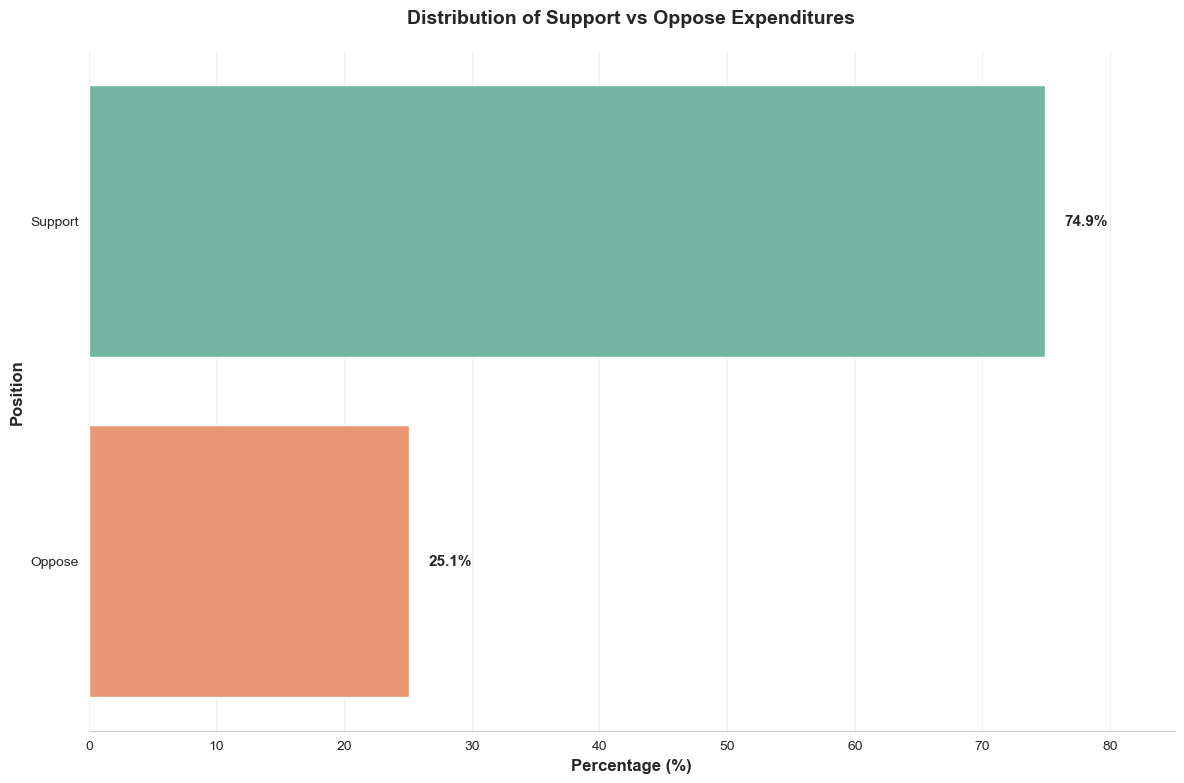

In [131]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

categories = ['Support', 'Oppose'] 
values = [74.9, 25.1]

plot_df = pd.DataFrame({
    'Category': categories,
    'Percentage': values
})

plt.figure(figsize=(12, 8))

ax = sns.barplot(data=plot_df, y='Category', x='Percentage', 
                palette='Set2', orient='h')

plt.title('Distribution of Support vs Oppose Expenditures', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Percentage (%)', fontsize=12, fontweight='bold')
plt.ylabel('Position', fontsize=12, fontweight='bold')

for i, (category, value) in enumerate(zip(categories, values)):
    ax.text(value + 1.5, i, f'{value}%', 
            va='center', ha='left', fontweight='bold', fontsize=11)

ax.grid(axis='x', alpha=0.3)
ax.set_axisbelow(True)
sns.despine(left=True, bottom=False)

plt.xlim(0, 85)

# Adjust layout and save
plt.tight_layout()
plt.savefig('images/support_oppose_seaborn.png', dpi=300, bbox_inches='tight')
plt.show()


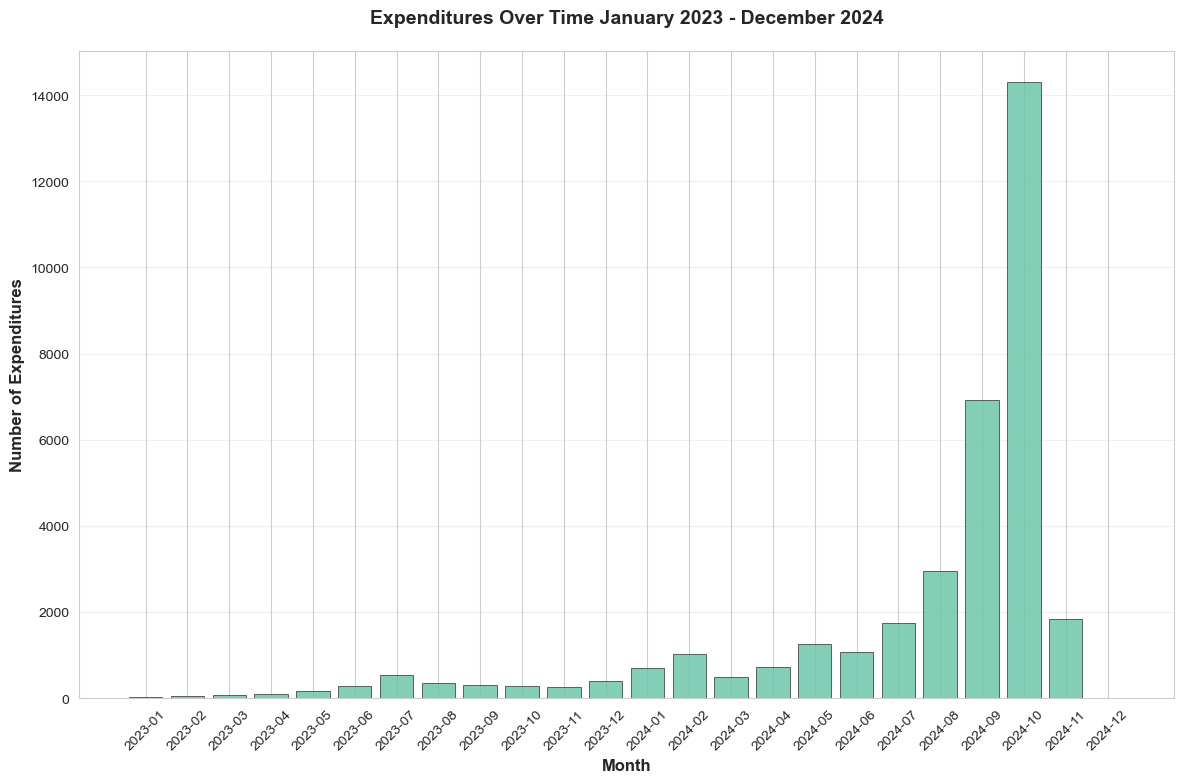

In [132]:
if 'exp_month' in df.columns:
    plt.figure(figsize=(12, 8))
    monthly_counts = df['exp_month'].value_counts().sort_index()
    
    colors = sns.color_palette('Set2', len(monthly_counts))
    plt.bar(range(len(monthly_counts)), monthly_counts.values, 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Month', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Expenditures', fontsize=12, fontweight='bold')
    plt.title('Expenditures Over Time January 2023 - December 2024', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(monthly_counts)), monthly_counts.index, rotation=45)
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('images/expenditures_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

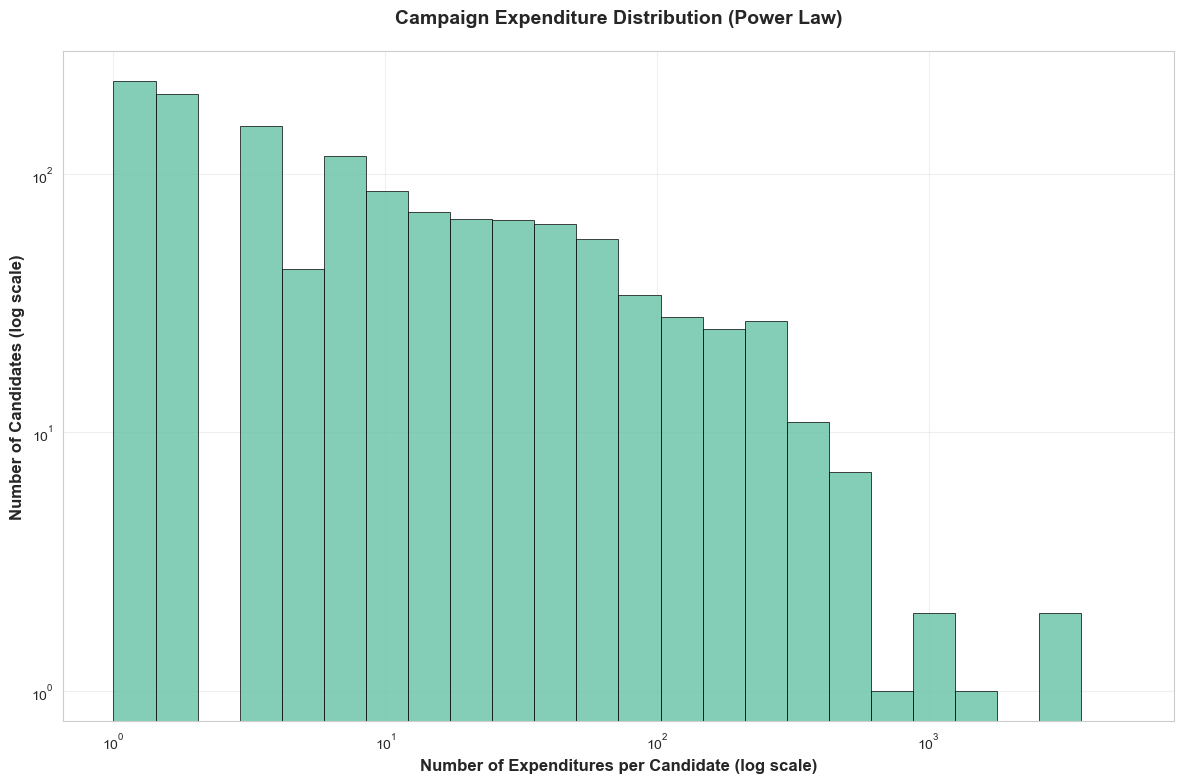

In [133]:
expenditures_per_candidate = df['cand_name'].value_counts()

plt.figure(figsize=(12, 8))
log_bins = np.logspace(0, np.log10(expenditures_per_candidate.max()), 25)

colors = sns.color_palette('Set2', 1)
sns.histplot(expenditures_per_candidate, bins=log_bins, alpha=0.8, 
             color=colors[0], edgecolor='black', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Expenditures per Candidate (log scale)', 
           fontsize=12, fontweight='bold')
plt.ylabel('Number of Candidates (log scale)', 
           fontsize=12, fontweight='bold')
plt.title('Campaign Expenditure Distribution (Power Law)', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/expenditure_amounts_by_party_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

AI assistance: Claude (Anthropic); prompts: "I am trying to capture a power law distribution in plotting campaign expenditure data - looking at Candidates and the count of expenditures... What would be a nice way to plot this as it tails off quickly from here. There are 1,323 entries. I would like to use seaborn. I am thinking a displot and would like some guidance on setting up bins to properly capture this" and "Explain this graph to me"; used for: generating Python code for power law visualization with logarithmic binning and seaborn, and explaining the resulting graph interpretation; changes: adapted the provided code examples to my specific dataset and selected the log-log scale approach; verification: tested the code with my campaign expenditure data, confirmed the power law pattern matches the theoretical expectations, and validated the graph interpretation against the raw data statistics.

KeyboardInterrupt: 

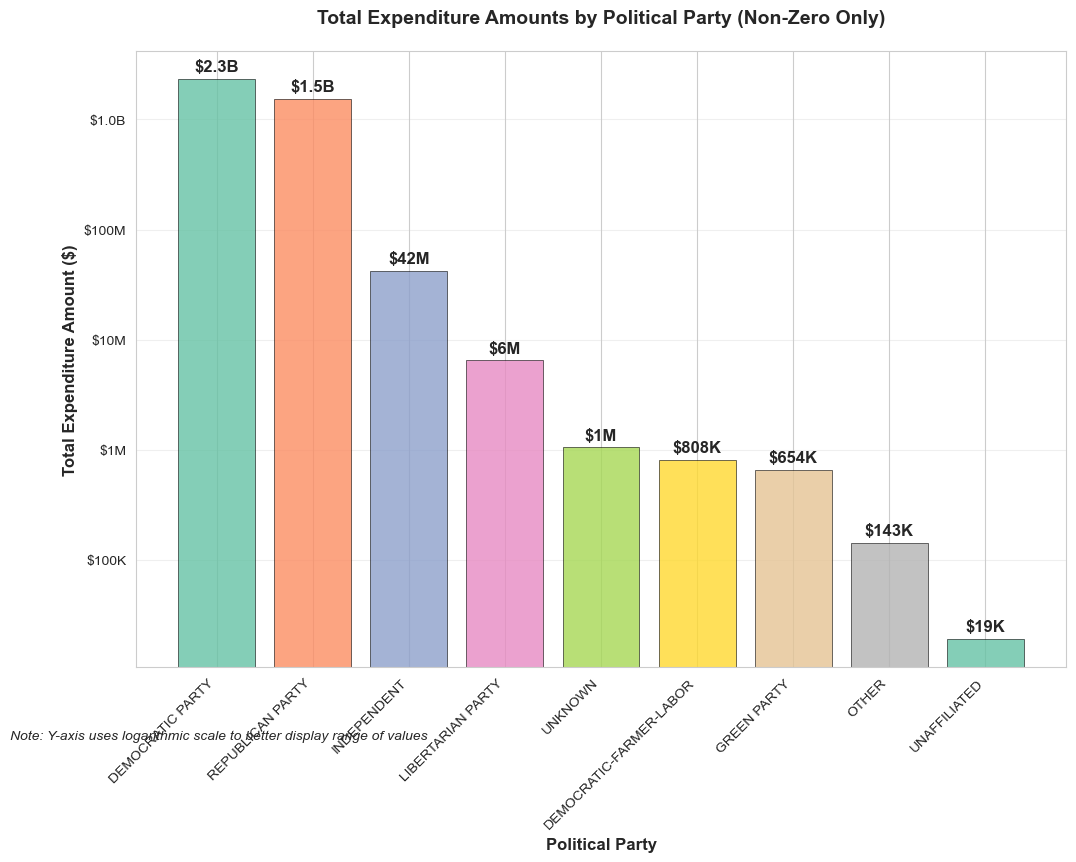

In [134]:
plt.figure(figsize=(12, 8))

party_expenditures = df.groupby('cand_pty_aff')['exp_amo'].sum().sort_values(ascending=False)

party_expenditures_filtered = party_expenditures[party_expenditures > 0]

colors = sns.color_palette('Set2', len(party_expenditures_filtered))

bars = plt.bar(range(len(party_expenditures_filtered)), party_expenditures_filtered.values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Political Party', fontsize=12, fontweight='bold')
plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
plt.title('Total Expenditure Amounts by Political Party (Non-Zero Only)', 
          fontsize=14, fontweight='bold', pad=20)

plt.xticks(range(len(party_expenditures_filtered)), party_expenditures_filtered.index, 
           rotation=45, ha='right')

plt.yscale('log')

def format_currency(x, p):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))

plt.grid(axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)

for i, (party, amount) in enumerate(party_expenditures_filtered.items()):
    if amount >= 1e9:
        label = f'${amount/1e9:.1f}B'
    elif amount >= 1e6:
        label = f'${amount/1e6:.0f}M'
    elif amount >= 1e3:
        label = f'${amount/1e3:.0f}K'
    else:
        label = f'${amount:.0f}'
    
    plt.text(i, amount * 1.1, label, ha='center', va='bottom', fontweight='bold')

plt.figtext(0.02, 0.02, 'Note: Y-axis uses logarithmic scale to better display range of values', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('images/expenditure_by_party_improved.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))

minor_parties = party_expenditures_filtered.iloc[2:]

if len(minor_parties) > 0:
    colors_minor = sns.color_palette('Set3', len(minor_parties))
    
    bars = plt.bar(range(len(minor_parties)), minor_parties.values, 
                   color=colors_minor, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Political Party', fontsize=12, fontweight='bold')
    plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
    plt.title('Expenditure Amounts by Minor Political Parties', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(range(len(minor_parties)), minor_parties.index, rotation=45, ha='right')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Add value labels
    for i, (party, amount) in enumerate(minor_parties.items()):
        if amount >= 1e6:
            label = f'${amount/1e6:.1f}M'
        elif amount >= 1e3:
            label = f'${amount/1e3:.0f}K'
        else:
            label = f'${amount:.0f}'
        
        plt.text(i, amount * 1.05, label, ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/minor_party_expenditures.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No minor parties with expenditures found for separate visualization.")

AI assistance: Claude (Anthropic Sonnet 4); prompts: "How can we improve this plot so that it better captures spending by party."; used for code optimization and data visualization improvements; changes: generated Python code with logarithmic scaling, filtered zero values, improved currency formatting, and created dual-chart approach; verification: reviewed code logic, formatting functions, and visualization principles for accuracy.

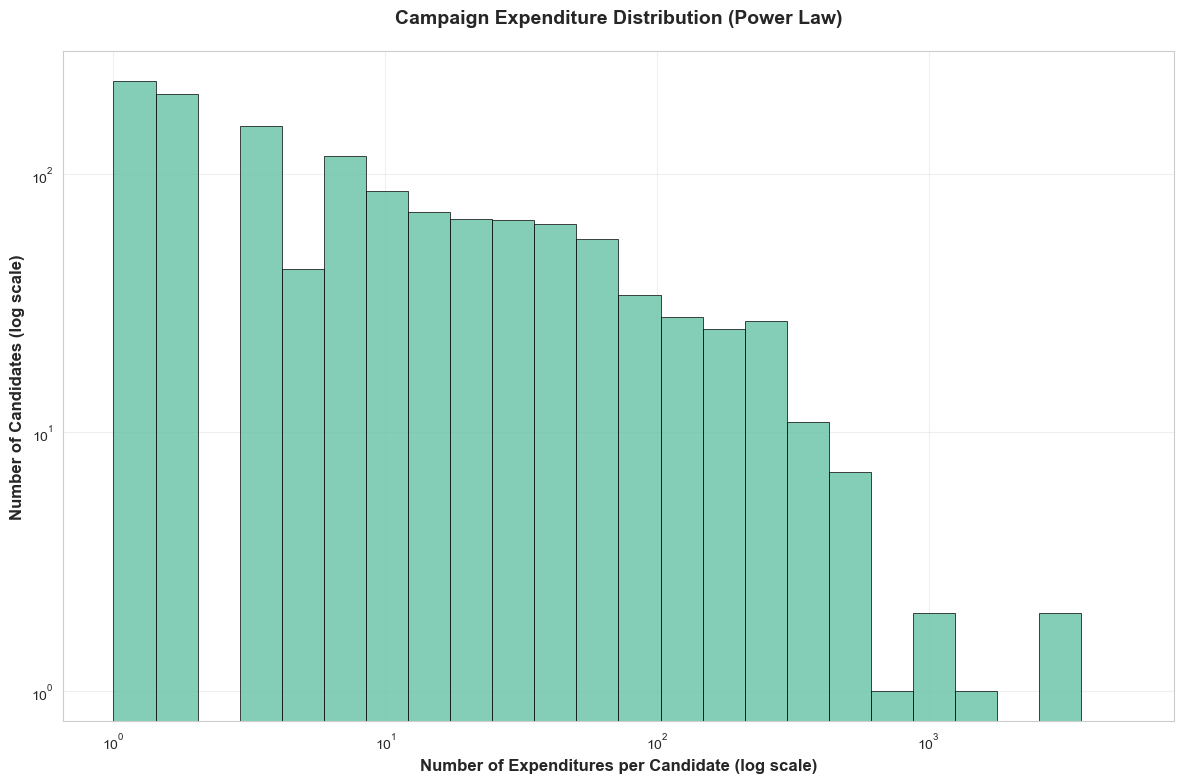

In [ ]:
expenditures_per_candidate = df['cand_name'].value_counts()

plt.figure(figsize=(12, 8))
log_bins = np.logspace(0, np.log10(expenditures_per_candidate.max()), 25)

colors = sns.color_palette('Set2', 1)
sns.histplot(expenditures_per_candidate, bins=log_bins, alpha=0.8, 
             color=colors[0], edgecolor='black', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Expenditures per Candidate (log scale)', 
           fontsize=12, fontweight='bold')
plt.ylabel('Number of Candidates (log scale)', 
           fontsize=12, fontweight='bold')
plt.title('Campaign Expenditure Distribution (Power Law)', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/expenditure_amounts_by_party_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

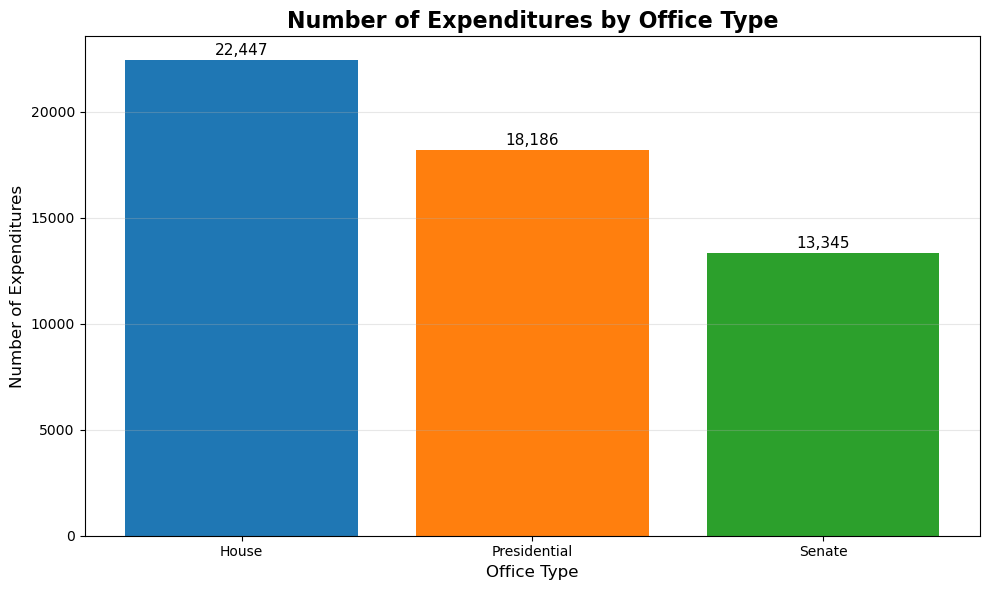

Expenditure counts by office:
House: 22,447
Presidential: 18,186
Senate: 13,345


In [ ]:
# Create bar chart for expenditures by can_office
can_office_counts = df['can_office'].value_counts()

# Map the codes to full names
office_names = {'H': 'House', 'P': 'Presidential', 'S': 'Senate'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar([office_names[code] for code in can_office_counts.index], 
               can_office_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Customize the plot
plt.title('Number of Expenditures by Office Type', fontsize=16, fontweight='bold')
plt.xlabel('Office Type', fontsize=12)
plt.ylabel('Number of Expenditures', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print the actual numbers
print("Expenditure counts by office:")
for code, count in can_office_counts.items():
    print(f"{office_names[code]}: {count:,}")


In [ ]:
# Get top 10 purposes for the x-axis
purpose_counts = df['pur'].value_counts()
top_10_purposes = purpose_counts.head(10)
print("Top 10 purposes:")
print(top_10_purposes)


Top 10 purposes:
pur
Payroll                                   1455
DIGITAL ADS                               1249
PHONEBANK PAYROLL SERVICES(ESTIMATE)      1128
PHONEBANK IT/TECH SUPPORT(ESTIMATE)       1117
CAGING AND DATABASE SERVICES(ESTIMATE)    1106
LEADS / PHONE LISTS(ESTIMATE)             1065
MEDIA PLACEMENT                            975
MEDIA PRODUCTION                           889
Digital Advertising                        758
MEDIA                                      610
Name: count, dtype: int64


In [ ]:
# Prepare data for the scatter plots
# Map office codes to full names
office_names = {'H': 'House', 'P': 'Presidential', 'S': 'Senate'}

# Create data for frequency plot (number of occurrences by purpose and office type)
frequency_data = []
for purpose in top_10_purposes.index:
    for office_code, office_name in office_names.items():
        count = len(df[(df['pur'] == purpose) & (df['can_office'] == office_code)])
        frequency_data.append({
            'purpose': purpose,
            'office_type': office_name,
            'count': count,
            'x_pos': list(top_10_purposes.index).index(purpose)
        })

frequency_df = pd.DataFrame(frequency_data)

# Create data for expenditure plot (dollar amounts by purpose and office type)
expenditure_data = []
for purpose in top_10_purposes.index:
    for office_code, office_name in office_names.items():
        amount = df[(df['pur'] == purpose) & (df['can_office'] == office_code)]['exp_amo'].sum()
        expenditure_data.append({
            'purpose': purpose,
            'office_type': office_name,
            'amount': amount,
            'x_pos': list(top_10_purposes.index).index(purpose)
        })

expenditure_df = pd.DataFrame(expenditure_data)

print("Frequency data sample:")
print(frequency_df.head())
print("\nExpenditure data sample:")
print(expenditure_df.head())


Frequency data sample:
       purpose   office_type  count  x_pos
0      Payroll         House    507      0
1      Payroll  Presidential    475      0
2      Payroll        Senate    473      0
3  DIGITAL ADS         House     27      1
4  DIGITAL ADS  Presidential     29      1

Expenditure data sample:
       purpose   office_type      amount  x_pos
0      Payroll         House   300071.45      0
1      Payroll  Presidential   956909.84      0
2      Payroll        Senate   740933.63      0
3  DIGITAL ADS         House  1487857.10      1
4  DIGITAL ADS  Presidential  1667814.26      1


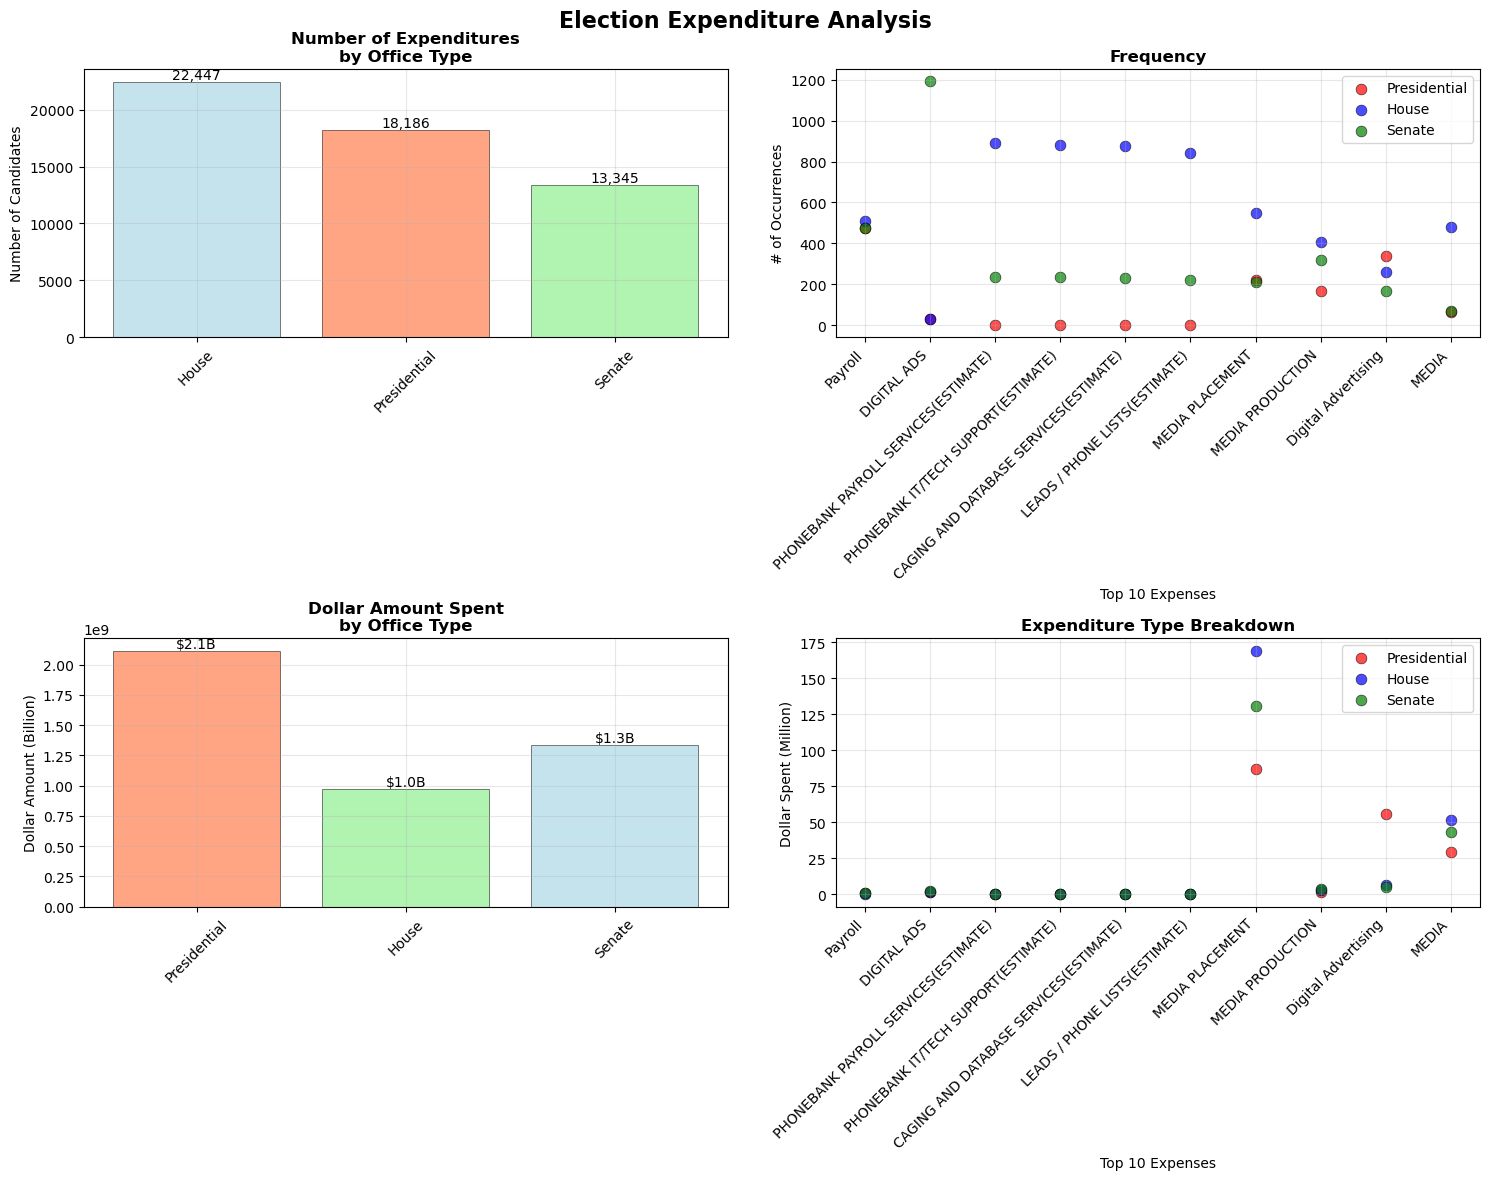

In [ ]:
# Create the updated 2x2 subplot with correct data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style
plt.style.use('default')
sns.set_palette("Set2")

# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Election Expenditure Analysis', fontsize=16, fontweight='bold')

# Top Left: Number of Expenditures by Office Type
ax1 = axes[0, 0]
office_types = ['House', 'Presidential', 'Senate']
expenditures_count = df['can_office'].value_counts()
# Reorder to match the desired order
expenditures_count_ordered = [expenditures_count['H'], expenditures_count['P'], expenditures_count['S']]

bars1 = ax1.bar(office_types, expenditures_count_ordered, 
                color=['lightblue', 'coral', 'lightgreen'],
                alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title('Number of Expenditures\nby Office Type', fontweight='bold')
ax1.set_ylabel('Number of Candidates')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Top Right: Frequency scatter plot
ax2 = axes[0, 1]
# Define colors for office types
office_colors = {'Presidential': 'red', 'House': 'blue', 'Senate': 'green'}

for office_type in ['Presidential', 'House', 'Senate']:
    office_data = frequency_df[frequency_df['office_type'] == office_type]
    ax2.scatter(office_data['x_pos'], office_data['count'], 
               c=office_colors[office_type], label=office_type, 
               alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

ax2.set_title('Frequency', fontweight='bold')
ax2.set_xlabel('Top 10 Expenses')
ax2.set_ylabel('# of Occurrences')
ax2.set_xticks(range(len(top_10_purposes)))
ax2.set_xticklabels(top_10_purposes.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Bottom Left: Dollar Amount Spent by Office Type
ax3 = axes[1, 0]
expenditures_dollars = df.groupby('can_office')['exp_amo'].sum()
# Reorder to match the desired order
expenditures_dollars_ordered = [expenditures_dollars['P'], expenditures_dollars['H'], expenditures_dollars['S']]
office_types_plot_2 = ['Presidential', 'House', 'Senate']

bars2 = ax3.bar(office_types_plot_2, expenditures_dollars_ordered,
                color=['coral', 'lightgreen', 'lightblue'],
                alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.set_title('Dollar Amount Spent\nby Office Type', fontweight='bold')
ax3.set_ylabel('Dollar Amount (Billion)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1e9:.1f}B',
             ha='center', va='bottom')

# Bottom Right: Expenditure Type Breakdown
ax4 = axes[1, 1]
for office_type in ['Presidential', 'House', 'Senate']:
    office_data = expenditure_df[expenditure_df['office_type'] == office_type]
    ax4.scatter(office_data['x_pos'], office_data['amount']/1e6, 
               c=office_colors[office_type], label=office_type,
               alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

ax4.set_title('Expenditure Type Breakdown', fontweight='bold')
ax4.set_xlabel('Top 10 Expenses')
ax4.set_ylabel('Dollar Spent (Million)')
ax4.set_xticks(range(len(top_10_purposes)))
ax4.set_xticklabels(top_10_purposes.index, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# save fig
plt.savefig('images/election_expenditure_analysis_better.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


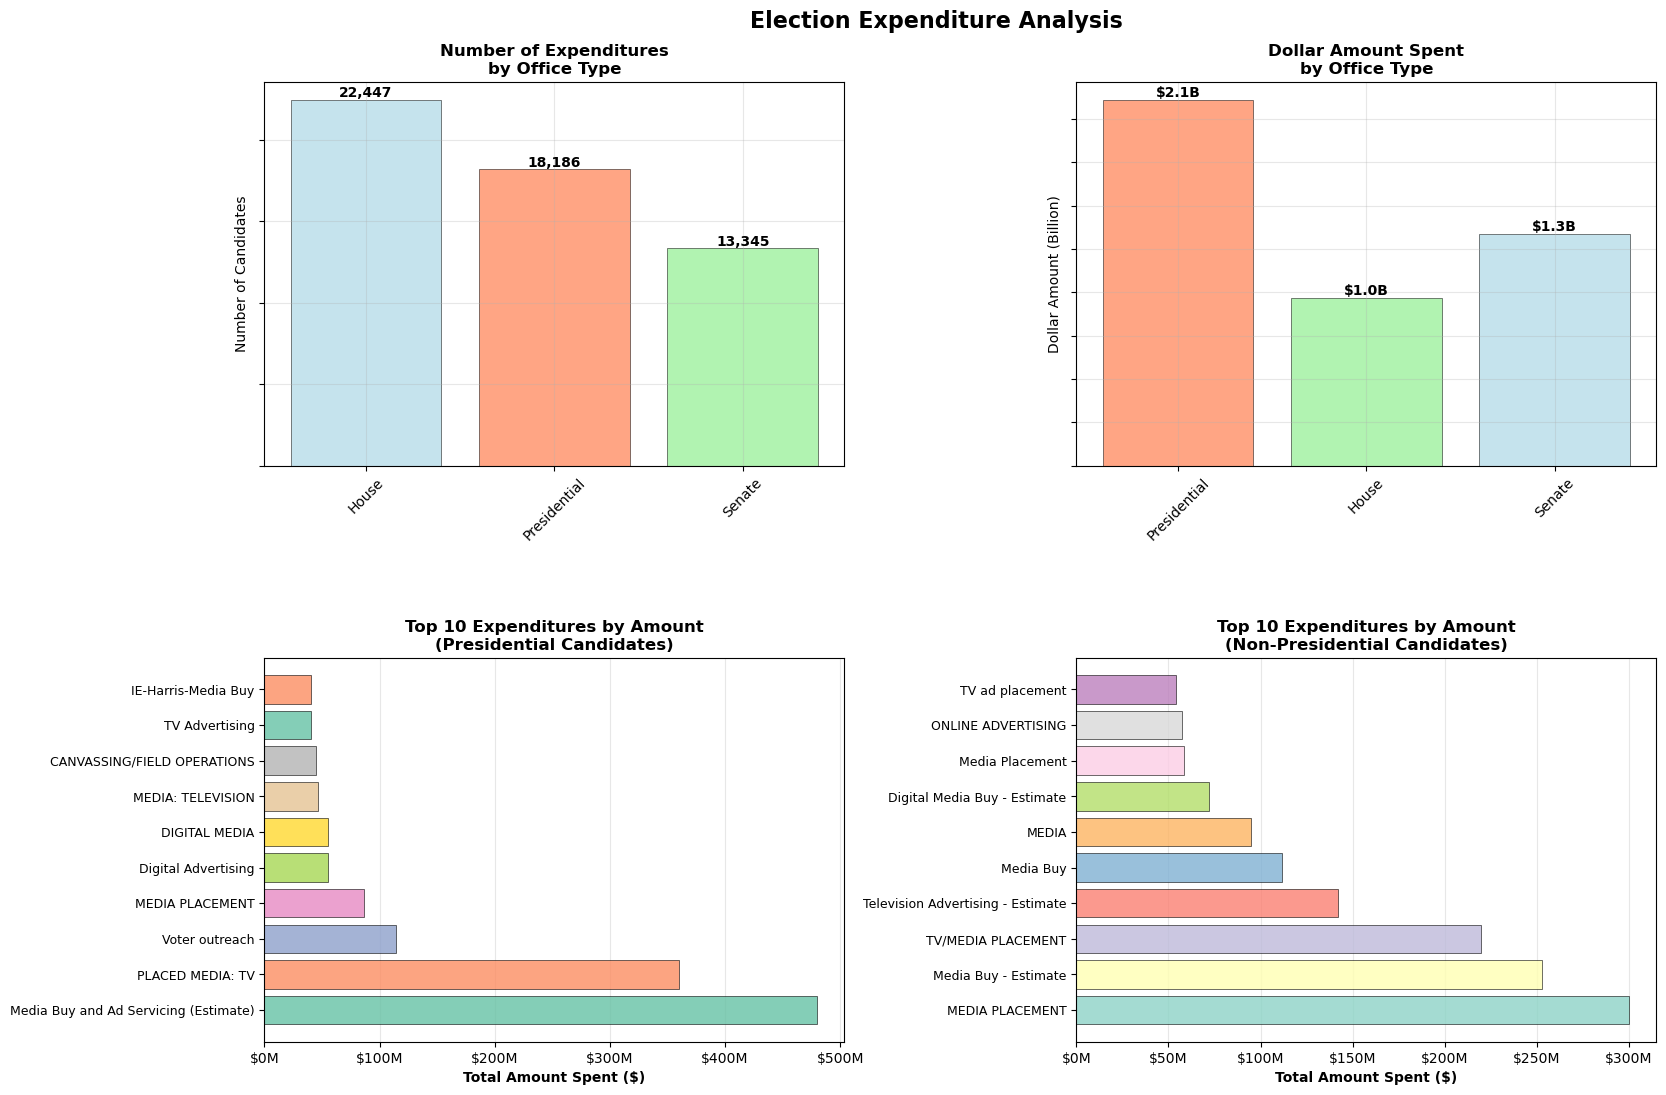

SUMMARY STATISTICS:
Presidential candidates total spending: $2,110,373,309.87
Non-presidential candidates total spending: $2,304,392,009.42
Total spending across all candidates: $4,415,014,497.82

Presidential spending as % of total: 47.8%
Non-presidential spending as % of total: 52.2%


In [ ]:
# Create combined 4-figure plot: vertical bar charts on top, horizontal bar charts on bottom
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style
plt.style.use('default')
sns.set_palette("Set2")

# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Election Expenditure Analysis', fontsize=16, fontweight='bold')

# Top Left: Number of Expenditures by Office Type
ax1 = axes[0, 0]
office_types = ['House', 'Presidential', 'Senate']
expenditures_count = df['can_office'].value_counts()
# Reorder to match the desired order
expenditures_count_ordered = [expenditures_count['H'], expenditures_count['P'], expenditures_count['S']]

bars1 = ax1.bar(office_types, expenditures_count_ordered, 
                color=['lightblue', 'coral', 'lightgreen'],
                alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title('Number of Expenditures\nby Office Type', fontweight='bold')
ax1.set_ylabel('Number of Candidates')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
# Remove y-axis tick labels for cleaner look
ax1.set_yticklabels([])

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold')

# Top Right: Dollar Amount Spent by Office Type
ax2 = axes[0, 1]
expenditures_dollars = df.groupby('can_office')['exp_amo'].sum()
# Reorder to match the desired order
expenditures_dollars_ordered = [expenditures_dollars['P'], expenditures_dollars['H'], expenditures_dollars['S']]
office_types_plot_2 = ['Presidential', 'House', 'Senate']

bars2 = ax2.bar(office_types_plot_2, expenditures_dollars_ordered,
                color=['coral', 'lightgreen', 'lightblue'],
                alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_title('Dollar Amount Spent\nby Office Type', fontweight='bold')
ax2.set_ylabel('Dollar Amount (Billion)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
# Remove y-axis tick labels for cleaner look
ax2.set_yticklabels([])

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1e9:.1f}B',
             ha='center', va='bottom', fontweight='bold')

# Bottom Left: Presidential candidates top expenditures
ax3 = axes[1, 0]
presidential_data = df[df['can_office'] == 'P']
presidential_expenditures = presidential_data.groupby('pur')['exp_amo'].sum().sort_values(ascending=False).head(10)

colors1 = sns.color_palette('Set2', len(presidential_expenditures))
bars3 = ax3.barh(range(len(presidential_expenditures)), presidential_expenditures.values, 
                color=colors1, alpha=0.8, edgecolor='black', linewidth=0.5)

ax3.set_title('Top 10 Expenditures by Amount\n(Presidential Candidates)', fontweight='bold', fontsize=12)
ax3.set_xlabel('Total Amount Spent ($)', fontsize=10, fontweight='bold')
ax3.set_yticks(range(len(presidential_expenditures)))
ax3.set_yticklabels(presidential_expenditures.index, fontsize=9)

# Format x-axis to show amounts in millions
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
ax3.grid(axis='x', alpha=0.3)
ax3.set_axisbelow(True)
# Remove exact amount labels for cleaner look

# Bottom Right: Non-presidential candidates top expenditures
ax4 = axes[1, 1]
non_presidential_data = df[df['can_office'].isin(['H', 'S'])]
non_presidential_expenditures = non_presidential_data.groupby('pur')['exp_amo'].sum().sort_values(ascending=False).head(10)

colors2 = sns.color_palette('Set3', len(non_presidential_expenditures))
bars4 = ax4.barh(range(len(non_presidential_expenditures)), non_presidential_expenditures.values, 
                color=colors2, alpha=0.8, edgecolor='black', linewidth=0.5)

ax4.set_title('Top 10 Expenditures by Amount\n(Non-Presidential Candidates)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Total Amount Spent ($)', fontsize=10, fontweight='bold')
ax4.set_yticks(range(len(non_presidential_expenditures)))
ax4.set_yticklabels(non_presidential_expenditures.index, fontsize=9)

# Format x-axis to show amounts in millions
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
ax4.grid(axis='x', alpha=0.3)
ax4.set_axisbelow(True)
# Remove exact amount labels for cleaner look

# Adjust layout for balanced white space
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.12, left=0.08, right=0.95, hspace=0.5, wspace=0.4)
plt.savefig('images/election_expenditure_analysis_iteration_2.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Print summary statistics
print("SUMMARY STATISTICS:")
print("=" * 60)
print(f"Presidential candidates total spending: ${presidential_data['exp_amo'].sum():,.2f}")
print(f"Non-presidential candidates total spending: ${non_presidential_data['exp_amo'].sum():,.2f}")
print(f"Total spending across all candidates: ${df['exp_amo'].sum():,.2f}")
print(f"\nPresidential spending as % of total: {(presidential_data['exp_amo'].sum() / df['exp_amo'].sum()) * 100:.1f}%")
print(f"Non-presidential spending as % of total: {(non_presidential_data['exp_amo'].sum() / df['exp_amo'].sum()) * 100:.1f}%")
